<h1>LSTM + CNN + MLPNN model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[],
                lstm_layers_unit_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))   
        
    print("num_of_lstm_layers:",len(lstm_layers_unit_array))    
    for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):       
        print("lstm_layer_unit["+str(i)+"]; unit:"+str(lstm_layer_unit))       
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
         
        # Add LSTM layers
        for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):    
            model.add(LSTM(lstm_layer_unit, return_sequences=True))
        
        # Add Conv layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))
                
        model.add(Dense(4))
        model.add(Activation('softmax'))   

        if len(conv_layers_filters_array) == 0 and len(dense_layers_unit_array) > 0 : 
            model.build(input_shape=(None, number_of_features))
        else:
            model.build(input_shape=(None, number_of_features, 1)) 

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train, test_dataset,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[],
                         lstm_layers_unit_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array,
                        lstm_layers_unit_array=lstm_layers_unit_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))
    


In [5]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train_for_mlpnn = X_train.copy()
X_validate_for_mlpnn = X_validate.copy()
X_test_for_mlpnn = X_test.copy()

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_train_for_mlpnn, y_train))
validate_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_validate_for_mlpnn, y_validate))
test_dataset_for_mlpnn = tf.data.Dataset.from_tensor_slices((X_test_for_mlpnn, y_test))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset_for_mlpnn.with_options(options)
validate_dataset_for_mlpnn.with_options(options)
test_dataset_for_mlpnn.with_options(options)

train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 30
train_dataset_for_mlpnn = train_dataset_for_mlpnn.batch(batch_size)
validate_dataset_for_mlpnn = validate_dataset_for_mlpnn.batch(batch_size)
test_dataset_for_mlpnn = test_dataset_for_mlpnn.batch(batch_size)

train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


<h3>Manual runs to get a feel of the hyperparameters</h3>

Start with just 1 LSTM layer on best CNN+MLPNN setup

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

Epoch 18/40
802/802 [==============================] - 145s 180ms/step - loss: 0.0189 - accuracy: 0.9938 - precision: 0.9939 - recall: 0.9930 - val_loss: 0.4092 - val_accuracy: 0.8873 - val_precision: 0.8918 - val_recall: 0.8827
Epoch 19/40
802/802 [==============================] - 145s 181ms/step - loss: 0.0169 - accuracy: 0.9944 - precision: 0.9951 - recall: 0.9944 - val_loss: 0.4132 - val_accuracy: 0.8868 - val_precision: 0.8920 - val_recall: 0.8838
Epoch 20/40
802/802 [==============================] - 145s 181ms/step - loss: 0.0171 - accuracy: 0.9949 - precision: 0.9950 - recall: 0.9946 - val_loss: 0.4116 - val_accuracy: 0.8879 - val_precision: 0.8918 - val_recall: 0.8845
Epoch 21/40
802/802 [==============================] - 145s 180ms/step - loss: 0.0131 - accuracy: 0.9958 - precision: 0.9959 - recall: 0.9957 - val_loss: 0.4275 - val_accuracy: 0.8872 - val_precision: 0.8911 - val_recall: 0.8832
Epoch 22/40
802/802 [==============================] - 145s 180ms/step - loss: 0.009

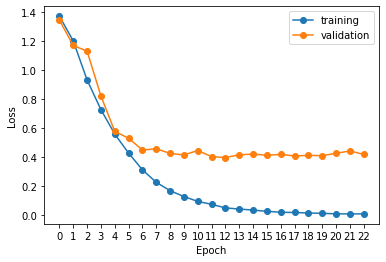

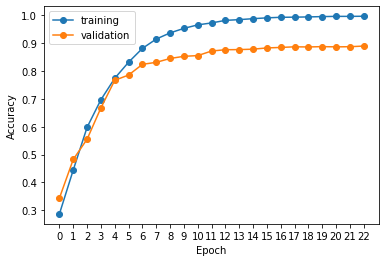

268/268 [==============================] - 17s 64ms/step - loss: 0.4036 - accuracy: 0.8963 - precision: 0.8987 - recall: 0.8934

Test Acc. 89.63%
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1978
           1       0.90      0.90      0.90      1957
           2       0.93      0.91      0.92      2069
           3       0.89      0.88      0.88      2011

   micro avg       0.90      0.90      0.90      8015
   macro avg       0.90      0.90      0.90      8015
weighted avg       0.90      0.90      0.90      8015
 samples avg       0.90      0.90      0.90      8015

Confusion matrix
[[1751  112   38   77]
 [ 114 1771   22   50]
 [  45   32 1893   99]
 [  95   56   91 1769]]


In [7]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     lstm_layers_unit_array=[256]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.2
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
______________________________________________

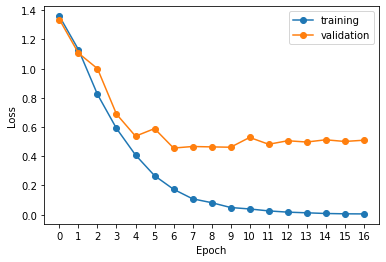

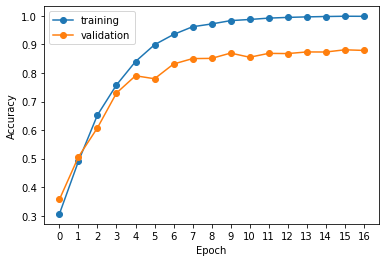

268/268 [==============================] - 18s 64ms/step - loss: 0.4827 - accuracy: 0.8843 - precision: 0.8881 - recall: 0.8823

Test Acc. 88.43%
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1978
           1       0.89      0.91      0.90      1957
           2       0.92      0.91      0.92      2069
           3       0.86      0.87      0.87      2011

   micro avg       0.88      0.88      0.88      8015
   macro avg       0.88      0.88      0.88      8015
weighted avg       0.88      0.88      0.88      8015
 samples avg       0.88      0.88      0.88      8015

Confusion matrix
[[1672  129   38  139]
 [  99 1776   21   61]
 [  60   40 1889   80]
 [ 102   60   98 1751]]


In [8]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.2,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     lstm_layers_unit_array=[256]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:100
conv_kernel[1]; unit:3
conv_strides[1]; unit:1
conv_layer_filters[2]; unit:100
conv_kernel[2]; unit:3
conv_strides[2]; unit:1
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.8
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
______________________________________________

Epoch 24/40
802/802 [==============================] - 144s 180ms/step - loss: 0.0648 - accuracy: 0.9748 - precision: 0.9776 - recall: 0.9723 - val_loss: 0.3615 - val_accuracy: 0.8828 - val_precision: 0.8916 - val_recall: 0.8751
Epoch 25/40
802/802 [==============================] - 144s 180ms/step - loss: 0.0563 - accuracy: 0.9804 - precision: 0.9823 - recall: 0.9782 - val_loss: 0.3736 - val_accuracy: 0.8833 - val_precision: 0.8911 - val_recall: 0.8783
Epoch 26/40
802/802 [==============================] - 144s 180ms/step - loss: 0.0524 - accuracy: 0.9830 - precision: 0.9846 - recall: 0.9806 - val_loss: 0.3631 - val_accuracy: 0.8886 - val_precision: 0.8947 - val_recall: 0.8836
Epoch 27/40
802/802 [==============================] - 144s 180ms/step - loss: 0.0457 - accuracy: 0.9842 - precision: 0.9860 - recall: 0.9829 - val_loss: 0.3573 - val_accuracy: 0.8898 - val_precision: 0.8964 - val_recall: 0.8842
Epoch 28/40
802/802 [==============================] - 144s 180ms/step - loss: 0.050

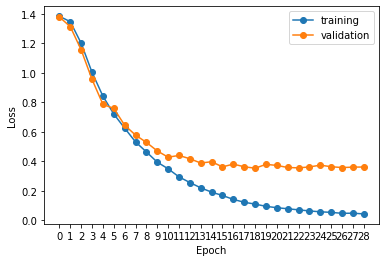

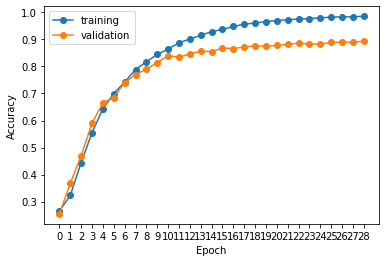

268/268 [==============================] - 17s 63ms/step - loss: 0.3555 - accuracy: 0.8926 - precision: 0.8981 - recall: 0.8885

Test Acc. 89.26%
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1978
           1       0.89      0.90      0.90      1957
           2       0.92      0.91      0.92      2069
           3       0.88      0.89      0.89      2011

   micro avg       0.89      0.89      0.89      8015
   macro avg       0.89      0.89      0.89      8015
weighted avg       0.89      0.89      0.89      8015
 samples avg       0.89      0.89      0.89      8015

Confusion matrix
[[1711  138   43   86]
 [ 103 1770   32   52]
 [  48   36 1890   95]
 [  91   52   85 1783]]


In [9]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.8,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     lstm_layers_unit_array=[256]
                    )

<h3>Hyperparam tuning on LSTM + CNN + MLPNN</h3>


In [7]:

number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array = [512]
    
    
    conv_layers_filters_array=[100,100,100]
    conv_kernel_size_array=[3,3,3]
    conv_strides_array=[1,1,1]
    
    lstm_layers_unit_array=[]
    
    lstm_layers_unit_array_size = hp.Int('lstm_layers_unit_array_size', min_value=1, max_value=2, step=1)
    for i in range(lstm_layers_unit_array_size):
        lstm_layers_unit_array.append(hp.Int('lstm_layers_unit_'+str(i), 
                                                min_value=128, max_value=512, step=64))
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=0.1,
                activation="relu", 
                isBatchNormalized=False, 
                dropOutRate=0.5,
                startWithBatchNormalized=True,      
                optimizer="SGD",   
                conv_layers_filters_array=conv_layers_filters_array,
                conv_kernel_size_array=conv_kernel_size_array,
                conv_strides_array=conv_strides_array,
                lstm_layers_unit_array=lstm_layers_unit_array
                       )
    
    return model
                        
             

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')

epochs = 40

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

print("Confusion matrix")
print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


Trial 75 Complete [00h 30m 02s]
val_accuracy: 0.8490142226219177

Best val_accuracy So Far: 0.8790866136550903
Total elapsed time: 18h 01m 05s

Search: Running Trial #76

Hyperparameter    |Value             |Best Value So Far 
lstm_layers_uni...|1                 |1                 
lstm_layers_unit_0|256               |256               
lstm_layers_unit_1|384               |192               
tuner/epochs      |14                |40                
tuner/initial_e...|0                 |14                
tuner/bracket     |1                 |3                 
tuner/round       |0                 |3                 

number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
num_of_conv_layers: 3
conv_layer_filters[0]; unit:100
conv_kernel[0]; unit:3
c

KeyboardInterrupt: 

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, test_dataset, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[100,100,100],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1],
                     lstm_layers_unit_array=[256]
                    )

<h3>Conclusion</h3>

Hyperparam tuning on LSTM + CNN + best MLPNN based model: same as manual tuning. </br>

 </br>

Manual tuning on LSTM + CNN + MLPNN: 89.63% accuracy </br>
num_of_dense_layers: 1 </br>
dense_layer[0]; unit:512 </br>
num_of_lstm_layers: 1 </br>
lstm_layer_unit[0]; unit:256 </br>
num_of_conv_layers: 3 </br>
conv_layer_filters[0]; unit:100 </br>
conv_kernel[0]; unit:3 </br>
conv_strides[0]; unit:1 </br>
conv_layer_filters[1]; unit:100 </br>
conv_kernel[1]; unit:3 </br>
conv_strides[1]; unit:1 </br>
conv_layer_filters[2]; unit:100 </br>
conv_kernel[2]; unit:3 </br>
conv_strides[2]; unit:1 </br>
learningRate: 0.1 </br>
isBatchNormalized: False </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: True </br>
optimizer: SGD </br>
activation: relu </br>

